In [1]:
# Cell 1: Imports and Setup
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import CIFAR10, ImageFolder
from torch.utils.data import DataLoader, Dataset
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
# Cell 2: Import FeatureExtractionNet from your Nets.py
from SAC_Distillation.Nets import FeatureExtractionNet


In [ ]:
# Cell 3: Data Augmentations and Dataset Wrappers

class ContrastiveTransform:
    def __init__(self, size=84):
        self.transform = T.Compose([
            T.Resize((size, size)),
            T.RandomResizedCrop(size, scale=(0.5, 1.0)),
            T.RandomHorizontalFlip(),
            T.RandomApply([T.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
            T.RandomGrayscale(p=0.2),
            T.Grayscale(num_output_channels=1),
            T.ToTensor(),
        ])

    def __call__(self, x):
        return self.transform(x)


class ContrastiveDataset(Dataset):
    def __init__(self, dataset, contrastive_transform):
        self.dataset = dataset
        self.transform = contrastive_transform

    def __getitem__(self, index):
        img, _ = self.dataset[index]
        # view1 = torch.cat([self.transform(img) for _ in range(4)], dim=0)
        # view2 = torch.cat([self.transform(img) for _ in range(4)], dim=0)
        view1 = self.transform(img)
        view2 = self.transform(img)
        return view1, view2

    def __len__(self):
        return len(self.dataset)



In [4]:
# Cell 4: Loss Function - NT-Xent Loss

class NTXentLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super().__init__()
        self.temperature = temperature

    def forward(self, z1, z2):
        z1 = F.normalize(z1, dim=1)
        z2 = F.normalize(z2, dim=1)
        batch_size = z1.shape[0]
        representations = torch.cat([z1, z2], dim=0)
        similarity = torch.mm(representations, representations.T) / self.temperature
        labels = torch.arange(batch_size, device=z1.device)
        labels = torch.cat([labels, labels], dim=0)
        mask = ~torch.eye(2 * batch_size, device=z1.device).bool()
        logits = similarity.masked_select(mask).view(2 * batch_size, -1)
        return F.cross_entropy(logits, labels)


In [ ]:
# Cell 5: Pretraining Function

def pretrain_contrastive(
    input_shape=(1, 84, 84),
    dataset_root="./data",
    dataset_type="CIFAR10",  # or "ImageFolder"
    custom_path=None,
    epochs=50,
    batch_size=128,
    temperature=0.5,
    save_path="SavedModels/feature_extractor_contrastive.pth"
):
    print("📦 Loading dataset...")
    transform = T.ToTensor()
    contrastive_transform = ContrastiveTransform(size=input_shape[1])

    if dataset_type == "CIFAR10":
        base_dataset = CIFAR10(root=dataset_root, train=True, download=True)
    elif dataset_type == "ImageFolder" and custom_path is not None:
        base_dataset = ImageFolder(root=custom_path)
    else:
        raise ValueError("Unsupported dataset type or missing custom path.")
    
    contrastive_dataset = ContrastiveDataset(base_dataset, contrastive_transform)
    loader = DataLoader(contrastive_dataset, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)

    model = FeatureExtractionNet(input_shape).to(device)
    loss_fn = NTXentLoss(temperature)
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

    model.train()
    print("🚀 Starting training...")
    loss_curve = []
    # for x1, x2 in loader:
    #     print("Batch loaded:", x1.shape, x2.shape)
    #     break

    for epoch in range(epochs):
        total_loss = 0
        for x1,x2 in tqdm(loader, desc=f"Epoch {epoch+1}/{epochs}"):
            x1, x2 = x1.to(device), x2.to(device)
            # print("Batch loaded:", x1.shape, x2.shape)
    
            z1 = model(x1, distill=False)
            z2 = model(x2, distill=False)

            loss = loss_fn(z1, z2)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(loader)
        loss_curve.append(avg_loss)
        print(f"Epoch {epoch+1} - Avg Loss: {avg_loss:.4f}")

    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    torch.save(model.state_dict(), save_path)
    print(f"✅ Model saved to: {save_path}")

    return loss_curve


In [8]:
# Cell 6: Run Pretraining

# You can set dataset_type="ImageFolder" and provide custom_path="path/to/your/images"
losses = pretrain_contrastive(
    dataset_type="CIFAR10",  # or "ImageFolder"
    input_shape=(1, 84, 84),  # Adjusted input shape to stack 4 images
    epochs=20,
    batch_size=256,
    temperature=0.5,
    save_path="SavedModels/feature_extractor_contrastive_init.pth"
)


📦 Loading dataset...
🚀 Starting training...


Epoch 1/20:   0%|          | 0/195 [00:01<?, ?it/s]

Batch loaded: torch.Size([256, 4, 84, 84]) torch.Size([256, 4, 84, 84])


RuntimeError: Given groups=1, weight of size [32, 1, 8, 8], expected input[256, 4, 84, 84] to have 1 channels, but got 4 channels instead

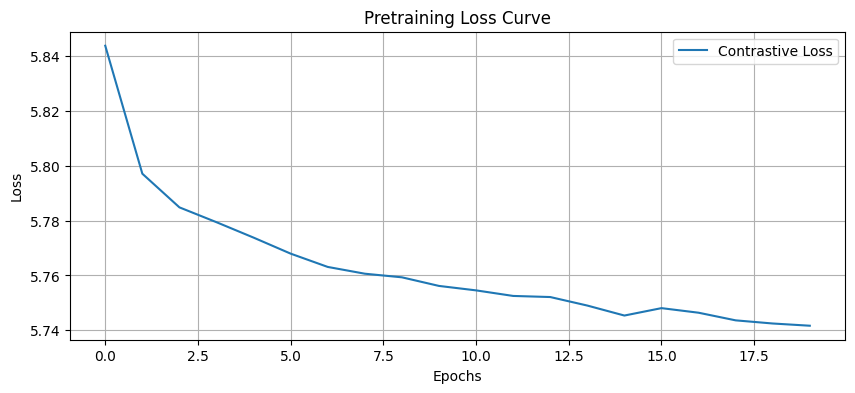

In [ ]:
# Cell 7: Plot the Loss Curve

plt.figure(figsize=(10, 4))
plt.plot(losses, label="Contrastive Loss")
plt.title("Pretraining Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()
